In [39]:
import numpy as np
from abc import ABC, abstractmethod
from scipy import linalg
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from typing import List, Optional, Union

# ==============================================================================
# 1. Abstract Strategy (The Interface)
# ==============================================================================

class ContextualRisk(ABC):
    """
    Abstract base class for defining the 'Risk' in data selection.
    This allows TAAQ to plug-and-play different objectives (Efficiency vs Robustness).
    """
    @abstractmethod
    def compute_multiplier(
        self,
        M_residual: np.ndarray,
        r_target: Optional[np.ndarray],
        candidates: np.ndarray,
        selected_indices: List[int],
        context: Optional[np.ndarray]
    ) -> np.ndarray:
        """
        Computes the penalty multiplier in [0, 1]. 
        1.0 = Safe (Keep Score), 0.0 = Risky (Suppress).
        """
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}()"

# ==============================================================================
# 2. Concrete Strategies (The Modules)
# ==============================================================================

class GeometricDiversityRisk(ContextualRisk):
    """
    Risk = Redundancy (Geometric Similarity).
    Used for: Efficiency tasks (Coreset, Token Selection).
    """
    def __init__(self, tau: float = 0.2, min_multiplier: float = 0.1):
        self.tau = tau
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context=None):
        n_features = M_residual.shape[1]
        
        # Optimization: Return ones if diversity is disabled or no selection yet
        if not selected_indices or self.tau <= 0:
            return np.ones(n_features)
            
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)

        # Normalize vectors in the current residual space
        X_cand = M_residual[:, active_idx]
        X_sel = M_residual[:, selected_indices]
        
        nc = np.linalg.norm(X_cand, axis=0) + 1e-12
        ns = np.linalg.norm(X_sel, axis=0) + 1e-12
        
        X_cand_n = X_cand / nc
        X_sel_n = X_sel / ns
        
        # Compute Max Cosine Similarity
        # shape: (n_selected, n_candidates) -> max -> (n_candidates,)
        sim = np.abs(X_sel_n.T @ X_cand_n)
        max_sim = np.max(sim, axis=0)
        
        # Compute Penalty: 1 - tau * similarity
        penalties = np.clip(1.0 - self.tau * max_sim, self.min_multiplier, 1.0)
        
        out = np.ones(n_features)
        out[active_idx] = penalties
        return out

    def __repr__(self):
        return f"GeometricDiversityRisk(tau={self.tau})"


class InvariantCausalRisk(ContextualRisk):
    """
    Risk = Instability (Variance across Environments).
    Used for: Robustness tasks (OOD Feature Selection).
    """
    def __init__(self, lambda_var: float = 2.0, lambda_flip: float = 1.0, thr: float = 0.05, min_multiplier: float = 1e-3, var_weighting: str = "count"):
        self.lambda_var = lambda_var
        self.lambda_flip = lambda_flip
        self.thr = thr
        self.min_multiplier = min_multiplier
        self.var_weighting = var_weighting

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        if context is None:
            raise ValueError("InvariantCausalRisk requires 'context' (environment IDs).")
        if r_target is None:
            raise ValueError("InvariantCausalRisk requires 'y' (target vector).")
            
        n_features = M_residual.shape[1]
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)
            
        eps = 1e-9
        Xa = M_residual[:, active_idx]
        
        # Handle environment statistics
        envs, counts = np.unique(context, return_counts=True)
        if envs.size < 2:
            # Cannot compute variance with < 2 environments
            return np.ones(n_features)
            
        corr_list, w_list = [], []
        for e, c in zip(envs, counts):
            mask = context == e
            if np.sum(mask) < 2: continue
                
            X_e = Xa[mask]
            y_e = r_target[mask]
            
            # Center and scale for correlation (slope) calculation
            y_e = y_e - y_e.mean()
            ny = np.linalg.norm(y_e) + eps
            
            X_e = X_e - X_e.mean(axis=0, keepdims=True)
            nx = np.linalg.norm(X_e, axis=0) + eps
            
            corr_e = (X_e.T @ y_e) / (nx * ny)
            corr_list.append(corr_e)
            w_list.append(float(c))
            
        if not corr_list:
            return np.ones(n_features)

        C = np.vstack(corr_list)
        
        # 1. Variance Risk (Weighted or Standard)
        if self.var_weighting == "count":
            w = np.asarray(w_list, dtype=float)
            w = w / (w.sum() + eps)
            mean = (w[:, None] * C).sum(axis=0)
            var_risk = (w[:, None] * (C - mean) ** 2).sum(axis=0)
        else:
            var_risk = np.var(C, axis=0)
        
        # 2. Sign-Flip Risk
        sig = np.abs(C) > self.thr
        has_pos = np.any((C > 0) & sig, axis=0)
        has_neg = np.any((C < 0) & sig, axis=0)
        flip_risk = (has_pos & has_neg).astype(float)
        
        # Total Penalty
        total_risk = self.lambda_var * var_risk + self.lambda_flip * flip_risk
        penalty = 1.0 / (1.0 + total_risk)
        
        penalty = np.clip(penalty, self.min_multiplier, 1.0)
        out = np.ones(n_features)
        out[active_idx] = penalty
        return out

    def __repr__(self):
        return f"InvariantCausalRisk(var={self.lambda_var}, flip={self.lambda_flip})"


class CompositeRisk(ContextualRisk):
    """
    Combines multiple risks (e.g., Efficiency + Robustness).
    """
    def __init__(self, risks: List[ContextualRisk], combine: str = "product", min_multiplier: float = 1e-3):
        self.risks = risks
        self.combine = combine
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        outs = [r.compute_multiplier(M_residual, r_target, candidates, selected_indices, context) for r in self.risks]
        
        if not outs:
            return np.ones(M_residual.shape[1])
            
        if self.combine == "product":
            m = np.prod(outs, axis=0)
        elif self.combine == "min":
            m = np.min(outs, axis=0)
        else: # average
            m = np.mean(outs, axis=0)
            
        return np.clip(m, self.min_multiplier, 1.0)

    def __repr__(self):
        return f"CompositeRisk(risks={self.risks})"


# ==============================================================================
# 3. The Unified Engine (TAAQ)
# ==============================================================================

class TAAQ(BaseEstimator, TransformerMixin):
    """
    The Unified Spectral Selection Engine.
    Delegates risk calculation to the injected 'risk_strategy'.
    """
    def __init__(self, k: int, risk_strategy: ContextualRisk, k1_ratio: float = 0.1, epsilon: float = 1e-9, verbose: bool = False):
        self.k = k
        self.risk_strategy = risk_strategy
        self.k1_ratio = k1_ratio
        self.epsilon = epsilon
        self.verbose = verbose
        self.selected_indices_ = None
        self.n_features_in_ = None

    def fit(self, X, y=None, context=None):
        """
        Fit the TAAQ model.
        """
        X = check_array(X)
        n_samples, n_features = X.shape
        
        if not (1 <= self.k <= n_features):
            raise ValueError(f"k must be in [1, n_features={n_features}].")
            
        self.n_features_in_ = n_features
        
        # Standardization (Required for Spectral Methods)
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0) + self.epsilon
        M = (X - X_mean) / X_std
        
        # Target Preprocessing
        r = None
        if y is not None:
            y = np.asarray(y, dtype=float)
            yc = y - y.mean()
            ny = np.linalg.norm(yc)
            if ny > self.epsilon:
                r = (yc / ny * np.sqrt(n_samples))
            else:
                r = yc
                
        # --- Phase 1: Spectral Gating (QRCP) ---
        k1 = int(self.k * self.k1_ratio)
        k1 = max(0, min(k1, n_features, self.k))
        S: List[int] = []
        
        if k1 > 0:
            Q, _, P = linalg.qr(M, mode="economic", pivoting=True)
            # Safety check for rank deficiency
            qcols = Q.shape[1]
            if qcols > 0:
                k1 = min(k1, qcols)
                S = list(P[:k1])
                Qg = Q[:, :k1]
                # Project out gated subspace
                M = M - Qg @ (Qg.T @ M)
                if r is not None:
                    r = r - Qg @ (Qg.T @ r)
            else:
                k1 = 0
        
        # --- Phase 2: Generalized Greedy Selection ---
        candidates = np.ones(n_features, dtype=bool)
        if S:
            candidates[S] = False
            
        while len(S) < self.k:
            # A. Compute Signal (Energy or Alignment)
            norms_sq = np.sum(M**2, axis=0)
            valid_mask = (norms_sq > self.epsilon) & candidates
            
            if not np.any(valid_mask):
                if self.verbose: print("Converged early: No more energy.")
                break
            
            if r is not None:
                # Supervised Alignment
                dots = M.T @ r
                signal = (dots**2) / (norms_sq + self.epsilon)
            else:
                # Unsupervised Energy
                signal = norms_sq
            
            # B. Compute Risk Multiplier (Strategy Call)
            mult = self.risk_strategy.compute_multiplier(M, r, valid_mask, S, context)
            
            # C. Selection
            scores = np.zeros(n_features)
            scores[valid_mask] = signal[valid_mask] * mult[valid_mask]
            
            best_idx = int(np.argmax(scores))
            S.append(best_idx)
            candidates[best_idx] = False
            
            # D. Residual Update (OMP Step)
            x = M[:, best_idx]
            nx = np.linalg.norm(x)
            
            if nx > self.epsilon:
                u = x / nx
                # M <- M - u u^T M
                proj = u @ M
                M = M - np.outer(u, proj)
                
                if r is not None:
                    r = r - (u @ r) * u
                    
        self.selected_indices_ = np.array(S, dtype=int)
        return self

    def transform(self, X):
        X = check_array(X)
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        return X[:, self.selected_indices_]

    def get_support(self, indices: bool = False):
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        if indices:
            return self.selected_indices_.copy()
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

    def fit_transform(self, X, y=None, context=None):
        self.fit(X, y=y, context=context)
        return self.transform(X)


# ==============================================================================
# 4. Factory Functions (User API)
# ==============================================================================

def TAAQ_Efficiency(k, k1_ratio=0.25, tau=0.2, min_multiplier=0.1):
    """Factory for Efficiency Mode (Geometric Diversity only)."""
    strategy = GeometricDiversityRisk(tau=tau, min_multiplier=min_multiplier)
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_RobustnessPure(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Robustness Mode.
    """
    strategy = InvariantCausalRisk(
        lambda_var=lambda_var, 
        lambda_flip=lambda_flip, 
        thr=thr, 
        min_multiplier=min_multiplier, 
        var_weighting=var_weighting
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_Hybrid(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, tau=0.2, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Hybrid Mode..
    """
    strategy = CompositeRisk(
        [
            InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting),
            GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)),
        ],
        combine="product",
        min_multiplier=min_multiplier,
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)
    
def TAAQ_Universal(k, k1_ratio=0.1, lambda_var=2.0, lambda_flip=1.0, thr=0.05, tau=0.0, min_multiplier=1e-3, var_weighting="count"):
    """Factory for auto-configuring based on parameters."""
    risks = [InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting)]
    if tau > 0:
        risks.append(GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)))
        strategy = CompositeRisk(risks, combine="product", min_multiplier=min_multiplier)
    else:
        strategy = risks[0]
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

Running OOD Experiment (EASY, SIGN-FLIP, VARIANCE-SHIFT, COVARIATE-SHIFT, LABEL-SHIFT)...


100%|██████████| 5/5 [05:08<00:00, 61.71s/it]


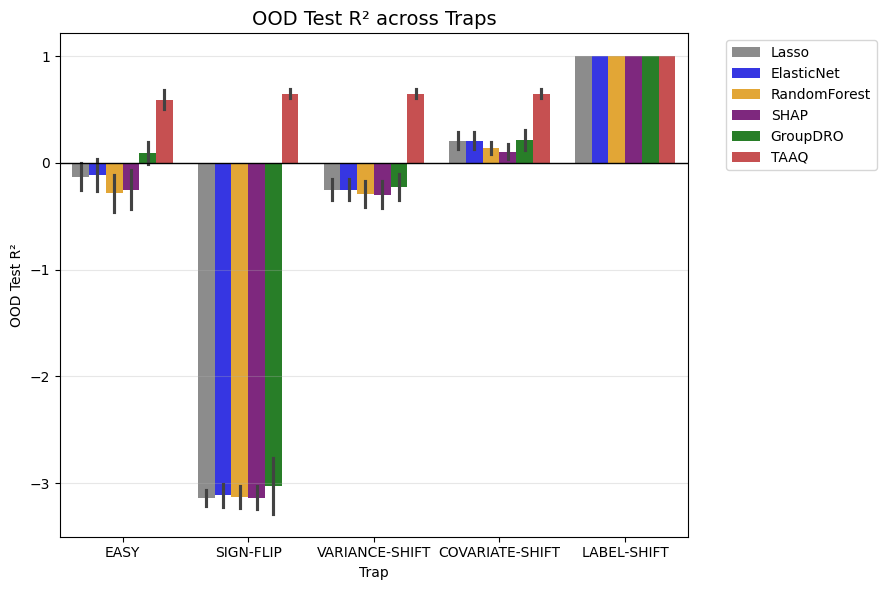

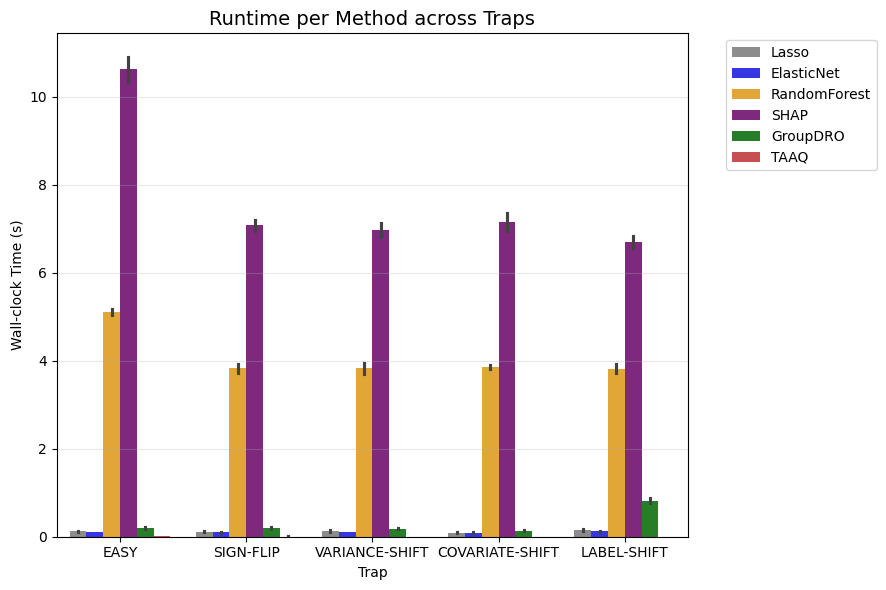


[OOD R2 Summary]
Method           ElasticNet  GroupDRO  Lasso  RandomForest   SHAP   TAAQ
Trap                                                                    
COVARIATE-SHIFT       0.209     0.214  0.209         0.139  0.106  0.646
EASY                 -0.113     0.090 -0.128        -0.285 -0.250  0.592
LABEL-SHIFT           0.999     0.999  0.999         0.998  0.999  0.999
SIGN-FLIP            -3.116    -3.029 -3.142        -3.130 -3.136  0.646
VARIANCE-SHIFT       -0.252    -0.226 -0.252        -0.290 -0.299  0.646

[OOD Time Summary]
Method           ElasticNet  GroupDRO  Lasso  RandomForest    SHAP   TAAQ
Trap                                                                     
COVARIATE-SHIFT       0.089     0.137  0.091         3.855   7.158  0.004
EASY                  0.111     0.202  0.119         5.111  10.625  0.006
LABEL-SHIFT           0.122     0.818  0.154         3.816   6.702  0.005
SIGN-FLIP             0.104     0.194  0.116         3.831   7.079  0.005
VARIANC

100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Running OOD Experiment with Redundancy...


100%|██████████| 2/2 [00:41<00:00, 20.55s/it]


Running OOD Experiment with Small Sample Sizes...


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


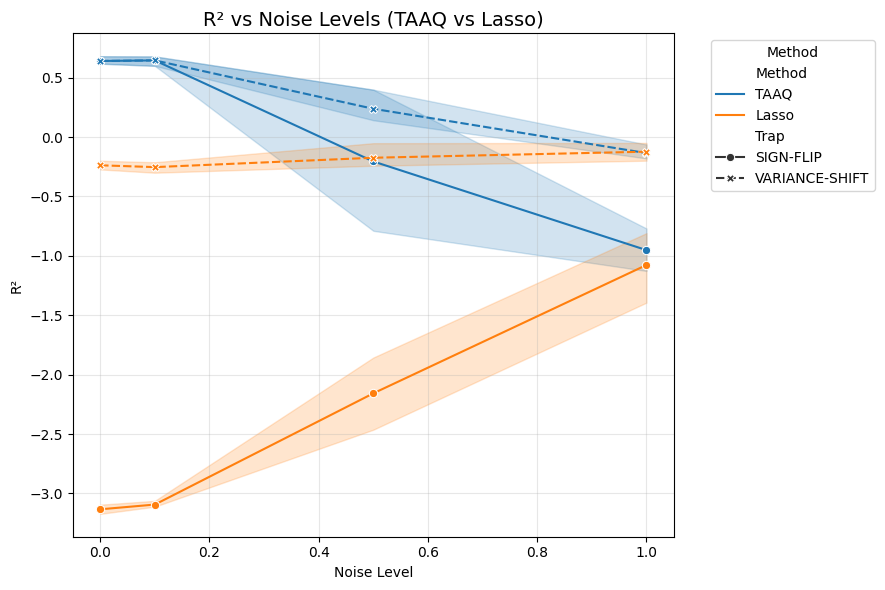

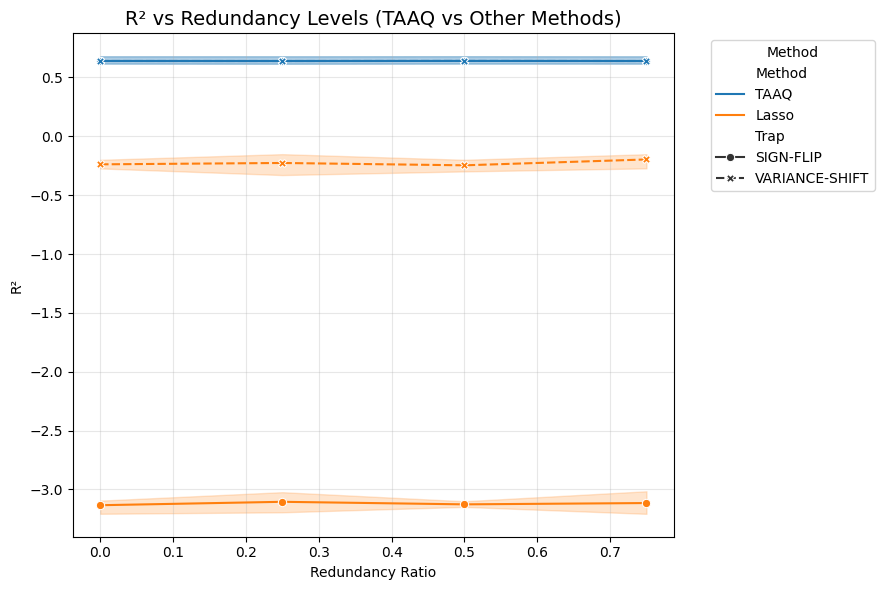

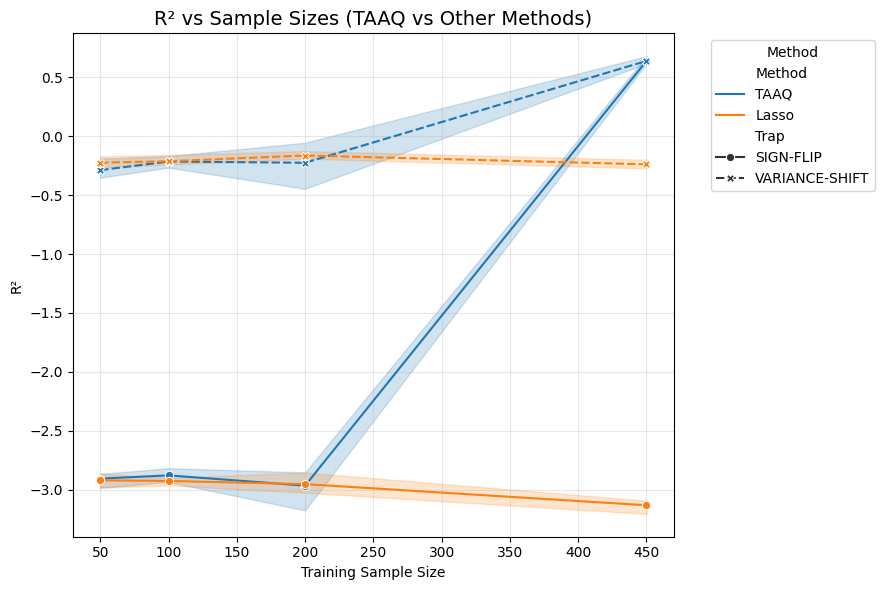


[Noise Robustness Summary]
Method                Lasso   TAAQ
Noise Trap                        
0.0   SIGN-FLIP      -3.134  0.640
      VARIANCE-SHIFT -0.238  0.640
0.1   SIGN-FLIP      -3.094  0.645
      VARIANCE-SHIFT -0.253  0.645
0.5   SIGN-FLIP      -2.157 -0.206
      VARIANCE-SHIFT -0.174  0.238
1.0   SIGN-FLIP      -1.077 -0.952
      VARIANCE-SHIFT -0.123 -0.135

[Redundancy Robustness Summary]
Method                     Lasso   TAAQ
Redundancy Trap                        
0.00       SIGN-FLIP      -3.134  0.640
           VARIANCE-SHIFT -0.238  0.640
0.25       SIGN-FLIP      -3.105  0.640
           VARIANCE-SHIFT -0.226  0.640
0.50       SIGN-FLIP      -3.126  0.641
           VARIANCE-SHIFT -0.246  0.641
0.75       SIGN-FLIP      -3.115  0.640
           VARIANCE-SHIFT -0.196  0.640

[Sample Size Robustness Summary]
Method                     Lasso   TAAQ
SampleSize Trap                        
50         SIGN-FLIP      -2.922 -2.907
           VARIANCE-SHIFT -0.224 -0

100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


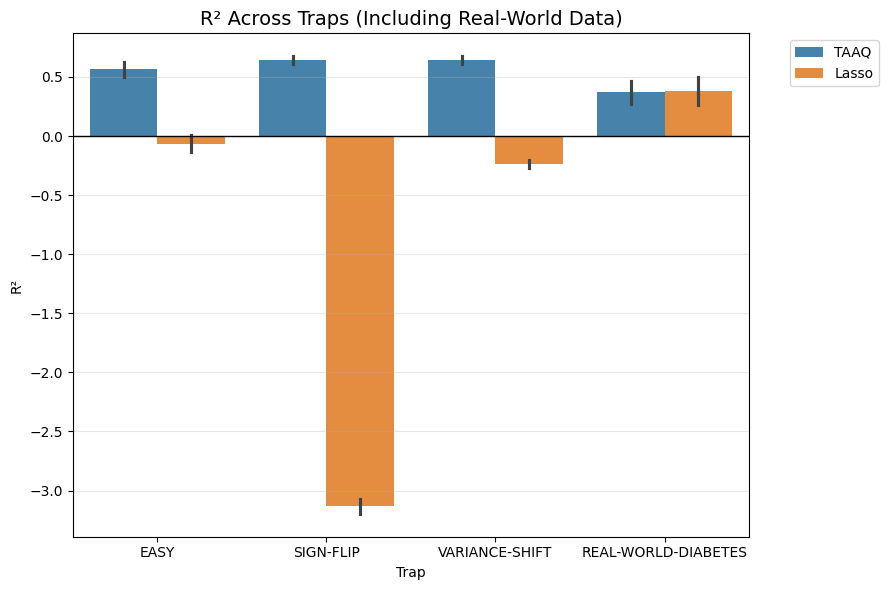


[Real-World Dataset R² Summary]
Method
Lasso    0.38
TAAQ     0.37
Name: R2, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LassoCV, Lasso, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import time
import warnings
import shap

from sklearn.datasets import load_diabetes

def load_real_world_dataset(dataset_name):
    if dataset_name == "diabetes":
        data = load_diabetes()
        X, y = data.data, data.target
        # Simulate environments (e.g., based on feature ranges or random splits)
        envs = np.random.randint(0, 4, size=len(y))
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    return X, y, envs


# from taaq import TAAQ_RobustnessPure

warnings.filterwarnings("ignore")


class GroupDROLasso:
    def __init__(self, k):
        self.k = k
        self.selected_indices_ = None

    def fit(self, X, y, environments):
        alphas = np.logspace(-3, 0.5, 30)
        best_score = -np.inf
        best_coef = None
        unique_envs = np.unique(environments)
        for alpha in alphas:
            model = Lasso(alpha=alpha, max_iter=2000)
            model.fit(X, y)
            env_scores = []
            for e in unique_envs:
                mask = environments == e
                if np.sum(mask) < 5:
                    continue
                env_scores.append(model.score(X[mask], y[mask]))
            if not env_scores:
                continue
            worst_score = np.min(env_scores)
            if worst_score > best_score:
                best_score = worst_score
                best_coef = model.coef_
        if best_coef is None:
            self.selected_indices_ = np.arange(self.k)
        else:
            self.selected_indices_ = np.argsort(-np.abs(best_coef))[:self.k]
        return self


def generate_easy_ood(seed, n=600, d=200):
    rng = np.random.default_rng(seed)
    n0, n1, n2, n3 = 300, 150, 100, 50
    env_ids = np.concatenate(
        [
            np.zeros(n0, dtype=int),
            np.ones(n1, dtype=int),
            np.full(n2, 2, dtype=int),
            np.full(n3, 3, dtype=int),
        ]
    )
    n_c = 10
    X_c = np.zeros((n, n_c))
    y_core = rng.normal(0, 1, n)
    for i in range(n):
        X_c[i] = 0.55 * y_core[i] + rng.normal(0, np.sqrt(1 - 0.55**2), n_c)
    y = y_core
    n_s = 20
    X_s = np.zeros((n, n_s))
    corrs = {0: 0.95, 1: 0.95, 2: 0.1, 3: 0.0}
    for i in range(n):
        env = int(env_ids[i])
        target_corr = corrs[env]
        noise_std = np.sqrt(max(1 - target_corr**2, 1e-9))
        X_s[i] = target_corr * y[i] + rng.normal(0, noise_std, n_s)
    X_n = rng.normal(0, 1, (n, d - n_c - n_s))
    X = np.hstack([X_c, X_s, X_n])
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y, env_ids

# Normal generate_trap function
def generate_trap(trap_type, seed, n=600, d=200):
    rng = np.random.default_rng(seed)
    n_env = 4
    env_ids = np.repeat(np.arange(n_env), n // n_env)
    n_c = 10
    X_c = np.zeros((n, n_c))
    y_core = rng.normal(0, 1, n)
    for i in range(n):
        X_c[i] = 0.55 * y_core[i] + rng.normal(0, np.sqrt(1 - 0.55**2), n_c)
    y = y_core
    n_s = 20
    X_s = np.zeros((n, n_s))
    
    if trap_type == "SIGN-FLIP":
        corrs = [0.95, 0.95, 0.6, -0.95]
    elif trap_type == "VARIANCE-SHIFT":
        corrs = [0.95, 0.95, 0.6, 0.0]
    elif trap_type == "COVARIATE-SHIFT":
        corrs = [0.95, 0.8, 0.5, 0.2]  # Gradual reduction in correlation
    elif trap_type == "LABEL-SHIFT":
        corrs = [0.95, 0.95, 0.95, 0.95]  
        y = y * (env_ids + 1)
    elif trap_type == "EASY":
        return generate_easy_ood(seed)
    elif trap_type == "diabetes":
        return load_real_world_dataset("diabetes") 
    else:
        raise ValueError("Unknown trap_type")
    
    
    for i in range(n):
        env = env_ids[i]
        target_corr = corrs[env]
        noise_std = np.sqrt(max(1 - target_corr**2, 1e-9))
        X_s[i] = target_corr * y[i] + rng.normal(0, noise_std, n_s)
    
    X_n = rng.normal(0, 1, (n, d - n_c - n_s))
    X = np.hstack([X_c, X_s, X_n])
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y, env_ids

def run_ood_experiment():
    scenarios = [
        ("EASY", "EASY"),
        ("SIGN-FLIP", "SIGN-FLIP"),
        ("VARIANCE-SHIFT", "VARIANCE-SHIFT"),
        ("COVARIATE-SHIFT", "COVARIATE-SHIFT"),
        ("LABEL-SHIFT", "LABEL-SHIFT"),
    ]
    seeds = [0, 1, 2, 3, 4]
    k_select = 5
    results = []
    print("Running OOD Experiment (EASY, SIGN-FLIP, VARIANCE-SHIFT, COVARIATE-SHIFT, LABEL-SHIFT)...")
    for trap_name, trap_type in tqdm(scenarios):
        for seed in seeds:
            if trap_type == "EASY":
                X, y, envs = generate_easy_ood(seed)
            else:
                X, y, envs = generate_trap(trap_type, seed)
            test_env = 3
            tr_mask = envs != test_env
            te_mask = envs == test_env
            X_tr, y_tr, E_tr = X[tr_mask], y[tr_mask], envs[tr_mask]
            X_te, y_te = X[te_mask], y[te_mask]
            methods = {
                "Lasso": LassoCV(cv=3),
                "ElasticNet": ElasticNetCV(cv=3),
                "RandomForest": RandomForestRegressor(n_estimators=100, random_state=seed),
                "SHAP": "SHAP",  # Placeholder for SHAP-based feature selection
                "GroupDRO": GroupDROLasso(k=k_select),
                "TAAQ": TAAQ_RobustnessPure(
                    k=k_select,
                    k1_ratio=0.0,
                    lambda_var=500.0,
                    lambda_flip=50.0,
                    min_multiplier=1e-9,
                ),
            }
            for name, model in methods.items():
                t0 = time.time()
                try:
                    if name == "TAAQ":
                        model.fit(X_tr, y_tr, context=E_tr)
                        idx = model.selected_indices_
                    elif name == "GroupDRO":
                        model.fit(X_tr, y_tr, environments=E_tr)
                        idx = model.selected_indices_
                    elif name == "RandomForest":
                        model.fit(X_tr, y_tr)
                        importances = model.feature_importances_
                        idx = np.argsort(-importances)[:k_select]
                    elif name == "SHAP":
                        explainer = shap.TreeExplainer(RandomForestRegressor(n_estimators=100, random_state=seed).fit(X_tr, y_tr))
                        shap_values = explainer.shap_values(X_tr)
                        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
                        idx = np.argsort(-mean_abs_shap)[:k_select]
                    else:  # Lasso and ElasticNet
                        model.fit(X_tr, y_tr)
                        coefs = np.abs(model.coef_)
                        idx = np.argsort(-coefs)[:k_select]
                    evaluator = Ridge(alpha=1.0)
                    evaluator.fit(X_tr[:, idx], y_tr)
                    r2 = r2_score(y_te, evaluator.predict(X_te[:, idx]))
                    t1 = time.time()
                    results.append(
                        {
                            "Trap": trap_name,
                            "Method": name,
                            "R2": r2,
                            "Time": t1 - t0,
                        }
                    )
                except Exception as e:
                    t1 = time.time()
                    results.append(
                        {
                            "Trap": trap_name,
                            "Method": name,
                            "R2": np.nan,
                            "Time": t1 - t0,
                        }
                    )
                    print(f"Error in {name} ({trap_name}, seed={seed}): {e}")
    return pd.DataFrame(results)

df_ood = run_ood_experiment()

palette_t = {
    "TAAQ": "#d62728",         # Red
    "GroupDRO": "green",       # Green
    "Lasso": "gray",           # Gray
    "ElasticNet": "blue",      # Blue
    "RandomForest": "orange",  # Orange
    "SHAP": "purple",          # Purple
}
palette_r2 = {
    "TAAQ": "#d62728",         # Red
    "GroupDRO": "green",       # Green
    "Lasso": "gray",           # Gray
    "ElasticNet": "blue",      # Blue
    "RandomForest": "orange",  # Orange
    "SHAP": "purple",          # Purple
}

# Plot OOD Test R² across Traps
plt.figure(figsize=(9, 6))
sns.barplot(
    data=df_ood,
    x="Trap",
    y="R2",
    hue="Method",
    palette=palette_r2,
    errorbar="sd",
    alpha=0.9,
)
plt.title("OOD Test R² across Traps", fontsize=14)
plt.ylabel("OOD Test R²")
plt.grid(axis="y", alpha=0.3)
plt.axhline(0, color="black", linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot Runtime per Method across Traps
plt.figure(figsize=(9, 6))
sns.barplot(
    data=df_ood,
    x="Trap",
    y="Time",
    hue="Method",
    palette=palette_t,
    errorbar="sd",
    alpha=0.9,
)
plt.title("Runtime per Method across Traps", fontsize=14)
plt.ylabel("Wall-clock Time (s)")
plt.grid(axis="y", alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("\n[OOD R2 Summary]")
print(df_ood.groupby(["Trap", "Method"])["R2"].mean().unstack().round(3))

print("\n[OOD Time Summary]")
print(df_ood.groupby(["Trap", "Method"])["Time"].mean().unstack().round(3))

#Robustness tests

def generate_trap_with_noise(trap_type, seed, noise_level=0.0, n=600, d=200):
    X, y, envs = generate_trap(trap_type, seed, n, d)
    rng = np.random.default_rng(seed)
    # Add Gaussian noise to features
    X += rng.normal(0, noise_level, X.shape)
    # Add Gaussian noise to labels
    y += rng.normal(0, noise_level, y.shape)
    return X, y, envs

def run_ood_experiment_with_noise():
    noise_levels = [0.0, 0.1, 0.5, 1.0]  # Different noise levels
    scenarios = [
        ("SIGN-FLIP", "SIGN-FLIP"),
        ("VARIANCE-SHIFT", "VARIANCE-SHIFT"),
    ]
    seeds = [0, 1, 2]
    k_select = 5
    results = []
    print("Running OOD Experiment with Noise...")
    for trap_name, trap_type in tqdm(scenarios):
        for noise_level in noise_levels:
            for seed in seeds:
                X, y, envs = generate_trap_with_noise(trap_type, seed, noise_level)
                test_env = 3
                tr_mask = envs != test_env
                te_mask = envs == test_env
                X_tr, y_tr, E_tr = X[tr_mask], y[tr_mask], envs[tr_mask]
                X_te, y_te = X[te_mask], y[te_mask]
                methods = {
                    "TAAQ": TAAQ_RobustnessPure(
                        k=k_select,
                        k1_ratio=0.0,
                        lambda_var=500.0,
                        lambda_flip=50.0,
                        min_multiplier=1e-9,
                    ),
                    "Lasso": LassoCV(cv=3),
                }
                for name, model in methods.items():
                    t0 = time.time()
                    try:
                        if name == "TAAQ":
                            model.fit(X_tr, y_tr, context=E_tr)
                            idx = model.selected_indices_
                        else:  # Lasso
                            model.fit(X_tr, y_tr)
                            coefs = np.abs(model.coef_)
                            idx = np.argsort(-coefs)[:k_select]
                        evaluator = Ridge(alpha=1.0)
                        evaluator.fit(X_tr[:, idx], y_tr)
                        r2 = r2_score(y_te, evaluator.predict(X_te[:, idx]))
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "Noise": noise_level,
                                "Method": name,
                                "R2": r2,
                                "Time": t1 - t0,
                            }
                        )
                    except Exception as e:
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "Noise": noise_level,
                                "Method": name,
                                "R2": np.nan,
                                "Time": t1 - t0,
                            }
                        )
                        print(f"Error in {name} ({trap_name}, seed={seed}): {e}")
    return pd.DataFrame(results)

df_noise = run_ood_experiment_with_noise()

def generate_trap_with_redundancy(trap_type, seed, redundancy_ratio=0.5, n=600, d=200):
    X, y, envs = generate_trap(trap_type, seed, n, d)
    rng = np.random.default_rng(seed)
    n_redundant = int(d * redundancy_ratio)
    redundant_features = X[:, :n_redundant] + rng.normal(0, 0.01, (n, n_redundant))
    X = np.hstack([X, redundant_features])
    return X, y, envs

def run_ood_experiment_with_redundancy():
    redundancy_ratios = [0.0, 0.25, 0.5, 0.75]  # Different redundancy levels
    scenarios = [
        ("SIGN-FLIP", "SIGN-FLIP"),
        ("VARIANCE-SHIFT", "VARIANCE-SHIFT"),
    ]
    seeds = [0, 1, 2]
    k_select = 5
    results = []
    print("Running OOD Experiment with Redundancy...")
    for trap_name, trap_type in tqdm(scenarios):
        for redundancy_ratio in redundancy_ratios:
            for seed in seeds:
                X, y, envs = generate_trap_with_redundancy(trap_type, seed, redundancy_ratio)
                test_env = 3
                tr_mask = envs != test_env
                te_mask = envs == test_env
                X_tr, y_tr, E_tr = X[tr_mask], y[tr_mask], envs[tr_mask]
                X_te, y_te = X[te_mask], y[te_mask]
                methods = {
                    "TAAQ": TAAQ_RobustnessPure(
                        k=k_select,
                        k1_ratio=0.0,
                        lambda_var=500.0,
                        lambda_flip=50.0,
                        min_multiplier=1e-9,
                    ),
                    "Lasso": LassoCV(cv=3),
                }
                for name, model in methods.items():
                    t0 = time.time()
                    try:
                        if name == "TAAQ":
                            model.fit(X_tr, y_tr, context=E_tr)
                            idx = model.selected_indices_
                        else:  # Lasso
                            model.fit(X_tr, y_tr)
                            coefs = np.abs(model.coef_)
                            idx = np.argsort(-coefs)[:k_select]
                        evaluator = Ridge(alpha=1.0)
                        evaluator.fit(X_tr[:, idx], y_tr)
                        r2 = r2_score(y_te, evaluator.predict(X_te[:, idx]))
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "Redundancy": redundancy_ratio,
                                "Method": name,
                                "R2": r2,
                                "Time": t1 - t0,
                            }
                        )
                    except Exception as e:
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "Redundancy": redundancy_ratio,
                                "Method": name,
                                "R2": np.nan,
                                "Time": t1 - t0,
                            }
                        )
                        print(f"Error in {name} ({trap_name}, seed={seed}): {e}")
    return pd.DataFrame(results)

df_redundancy = run_ood_experiment_with_redundancy()

def run_ood_experiment_with_small_samples():
    sample_sizes = [50, 100, 200, 450]  # Include the full training size
    scenarios = [
        ("SIGN-FLIP", "SIGN-FLIP"),
        ("VARIANCE-SHIFT", "VARIANCE-SHIFT"),
    ]
    seeds = [0, 1, 2]
    k_select = 5
    results = []
    print("Running OOD Experiment with Small Sample Sizes...")
    for trap_name, trap_type in tqdm(scenarios):
        for sample_size in sample_sizes:
            for seed in seeds:
                X, y, envs = generate_trap(trap_type, seed)
                test_env = 3
                tr_mask = envs != test_env
                te_mask = envs == test_env
                X_tr, y_tr, E_tr = X[tr_mask][:sample_size], y[tr_mask][:sample_size], envs[tr_mask][:sample_size]
                X_te, y_te = X[te_mask], y[te_mask]
                methods = {
                    "TAAQ": TAAQ_RobustnessPure(
                        k=k_select,
                        k1_ratio=0.0,
                        lambda_var=500.0,
                        lambda_flip=50.0,
                        min_multiplier=1e-9,
                    ),
                    "Lasso": LassoCV(cv=3),
                }
                for name, model in methods.items():
                    t0 = time.time()
                    try:
                        if name == "TAAQ":
                            model.fit(X_tr, y_tr, context=E_tr)
                            idx = model.selected_indices_
                        else:  # Lasso
                            model.fit(X_tr, y_tr)
                            coefs = np.abs(model.coef_)
                            idx = np.argsort(-coefs)[:k_select]
                        evaluator = Ridge(alpha=1.0)
                        evaluator.fit(X_tr[:, idx], y_tr)
                        r2 = r2_score(y_te, evaluator.predict(X_te[:, idx]))
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "SampleSize": sample_size,
                                "Method": name,
                                "R2": r2,
                                "Time": t1 - t0,
                            }
                        )
                    except Exception as e:
                        t1 = time.time()
                        results.append(
                            {
                                "Trap": trap_name,
                                "SampleSize": sample_size,
                                "Method": name,
                                "R2": np.nan,
                                "Time": t1 - t0,
                            }
                        )
                        print(f"Error in {name} ({trap_name}, seed={seed}): {e}")
    return pd.DataFrame(results)

df_small_samples = run_ood_experiment_with_small_samples()

# Visualize R² vs Noise Levels
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=df_noise,
    x="Noise",
    y="R2",
    hue="Method",
    style="Trap",
    markers=True,
    palette="tab10",
)
plt.title("R² vs Noise Levels (TAAQ vs Lasso)", fontsize=14)
plt.xlabel("Noise Level")
plt.ylabel("R²")
plt.grid(alpha=0.3)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Visualize R² vs Redundancy Levels
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=df_redundancy,
    x="Redundancy",
    y="R2",
    hue="Method", 
    style="Trap",  
    markers=True,
    palette="tab10",
)
plt.title("R² vs Redundancy Levels (TAAQ vs Other Methods)", fontsize=14)
plt.xlabel("Redundancy Ratio")
plt.ylabel("R²")
plt.grid(alpha=0.3)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Visualize R² vs Sample Sizes
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=df_small_samples,
    x="SampleSize",
    y="R2",
    hue="Method",  # Compare methods
    style="Trap",  # Different line styles for traps
    markers=True,
    palette="tab10",
)
plt.title("R² vs Sample Sizes (TAAQ vs Other Methods)", fontsize=14)
plt.xlabel("Training Sample Size")
plt.ylabel("R²")
plt.grid(alpha=0.3)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Print the full Data
print("\n[Noise Robustness Summary]")
print(df_noise.groupby(["Noise", "Trap", "Method"])["R2"].mean().unstack().round(3))

print("\n[Redundancy Robustness Summary]")
print(df_redundancy.groupby(["Redundancy", "Trap", "Method"])["R2"].mean().unstack().round(3))

print("\n[Sample Size Robustness Summary]")
print(df_small_samples.groupby(["SampleSize", "Trap", "Method"])["R2"].mean().unstack().round(3))

#Ran experiemnt on real world data

def run_ood_experiment_with_real_world():
    scenarios = [
        ("EASY", "EASY"),
        ("SIGN-FLIP", "SIGN-FLIP"),
        ("VARIANCE-SHIFT", "VARIANCE-SHIFT"),
        ("REAL-WORLD-DIABETES", "diabetes"),  # Add real-world dataset
    ]
    seeds = [0, 1, 2]
    k_select = 5
    results = []
    print("Running OOD Experiment with Real-World Data...")
    for trap_name, trap_type in tqdm(scenarios):
        for seed in seeds:
            if trap_type in ["EASY", "SIGN-FLIP", "VARIANCE-SHIFT"]:
                X, y, envs = generate_trap(trap_type, seed)
            elif trap_type == "diabetes":  # Handle real-world dataset
                X, y, envs = load_real_world_dataset("diabetes")
            else:
                raise ValueError(f"Unknown trap_type: {trap_type}")
            test_env = 3
            tr_mask = envs != test_env
            te_mask = envs == test_env
            X_tr, y_tr, E_tr = X[tr_mask], y[tr_mask], envs[tr_mask]
            X_te, y_te = X[te_mask], y[te_mask]
            methods = {
                "TAAQ": TAAQ_RobustnessPure(
                    k=k_select,
                    k1_ratio=0.0,
                    lambda_var=500.0,
                    lambda_flip=50.0,
                    min_multiplier=1e-9,
                ),
                "Lasso": LassoCV(cv=3),
            }
            for name, model in methods.items():
                t0 = time.time()
                try:
                    if name == "TAAQ":
                        model.fit(X_tr, y_tr, context=E_tr)
                        idx = model.selected_indices_
                    else:  # Lasso
                        model.fit(X_tr, y_tr)
                        coefs = np.abs(model.coef_)
                        idx = np.argsort(-coefs)[:k_select]
                    evaluator = Ridge(alpha=1.0)
                    evaluator.fit(X_tr[:, idx], y_tr)
                    r2 = r2_score(y_te, evaluator.predict(X_te[:, idx]))
                    t1 = time.time()
                    results.append(
                        {
                            "Trap": trap_name,
                            "Method": name,
                            "R2": r2,
                            "Time": t1 - t0,
                        }
                    )
                except Exception as e:
                    t1 = time.time()
                    results.append(
                        {
                            "Trap": trap_name,
                            "Method": name,
                            "R2": np.nan,
                            "Time": t1 - t0,
                        }
                    )
                    print(f"Error in {name} ({trap_name}, seed={seed}): {e}")
    return pd.DataFrame(results)

df_real_world = run_ood_experiment_with_real_world()

plt.figure(figsize=(9, 6))
sns.barplot(
    data=df_real_world,
    x="Trap",
    y="R2",
    hue="Method",
    palette="tab10",
    errorbar="sd",
    alpha=0.9,
)
plt.title("R² Across Traps (Including Real-World Data)", fontsize=14)
plt.ylabel("R²")
plt.grid(axis="y", alpha=0.3)
plt.axhline(0, color="black", linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("\n[Real-World Dataset R² Summary]")
print(df_real_world[df_real_world["Trap"] == "REAL-WORLD-DIABETES"].groupby("Method")["R2"].mean().round(3))